# CNN
For taking in a 56x56 ball and determining if it's stripe, solid, or the aim circle

In [4]:
import project
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import cv2
import json
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from pathlib import Path
from PIL import Image
from pathlib import Path
from models import BallCNN

constants = json.load(open('constants.json'))

In [5]:
class BallDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.data = []
        self.labels = []
        self.augment = augment

        label_map = {'stripe': 0, 'solid': 1, 'aim_circle': 2}
        root_path = Path(root_dir)

        for label_name, label_value in label_map.items():
            folder_path = root_path / label_name
            for fpath in folder_path.iterdir():
                if fpath.is_file():
                    self.data.append(fpath)
                    self.labels.append(label_value)

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(90),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()
        ]) if augment else transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_np = project.preprocess_file(str(self.data[idx]), size=56, padding=0, thresh_1=(0.5,1.1), thresh_2=(0.9,1.1), close_size=2, open_size=2)
        img = self.transform(img_np)
        return img, self.labels[idx]

# create train/val/test splits
base_dataset = BallDataset('labeling/', augment=False)
train_size = int(0.7 * len(base_dataset))
val_size = int(0.15 * len(base_dataset))
test_size = len(base_dataset) - train_size - val_size


train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(base_dataset)), [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset = Subset(BallDataset('labeling/', augment=True), train_indices)
val_dataset   = Subset(BallDataset('labeling/', augment=False), val_indices)
test_dataset  = Subset(BallDataset('labeling/', augment=False), test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [6]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = BallCNN().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


best_val_acc = 0.0
best_model_state = None
best_epoch = 0

for epoch in range(30):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        preds = model(images)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            predicted = preds.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

print(f"\nBest model was from epoch {best_epoch} with Val Accuracy: {best_val_acc:.4f}")

model.load_state_dict(best_model_state)

Using device: cuda
Epoch 1, Train Loss: 18.8855, Val Accuracy: 0.5194
Epoch 2, Train Loss: 15.5439, Val Accuracy: 0.8217
Epoch 3, Train Loss: 12.9351, Val Accuracy: 0.7907
Epoch 4, Train Loss: 10.2916, Val Accuracy: 0.8217
Epoch 5, Train Loss: 8.3312, Val Accuracy: 0.8295
Epoch 6, Train Loss: 7.0358, Val Accuracy: 0.9147
Epoch 7, Train Loss: 6.1579, Val Accuracy: 0.9302
Epoch 8, Train Loss: 5.5550, Val Accuracy: 0.9457
Epoch 9, Train Loss: 5.1998, Val Accuracy: 0.9147
Epoch 10, Train Loss: 5.0918, Val Accuracy: 0.9457
Epoch 11, Train Loss: 4.8814, Val Accuracy: 0.9457
Epoch 12, Train Loss: 4.6676, Val Accuracy: 0.9302
Epoch 13, Train Loss: 4.6746, Val Accuracy: 0.9535
Epoch 14, Train Loss: 4.6588, Val Accuracy: 0.9612
Epoch 15, Train Loss: 4.5433, Val Accuracy: 0.9380
Epoch 16, Train Loss: 4.4669, Val Accuracy: 0.9380
Epoch 17, Train Loss: 4.4220, Val Accuracy: 0.9457
Epoch 18, Train Loss: 4.2902, Val Accuracy: 0.9612
Epoch 19, Train Loss: 4.3875, Val Accuracy: 0.9380
Epoch 20, Train L

<All keys matched successfully>

In [7]:
# test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        predicted = preds.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8923


In [79]:
# save model
torch.save(model.state_dict(), 'ball_type.pth')

In [ ]:
# manually test a few images from each class
label_names = ['stripe', 'solid', 'aim_circle']


def test_image(model, image_path, show=True):
    model.eval()
    actual_label = Path(image_path).parent.name
    original_img = Image.open(image_path) 
    img_np = project.preprocess_file(image_path, size=56, padding=0,
                                     thresh_1=(0.5, 1.1), thresh_2=(0.9, 1.1),
                                     close_size=2, open_size=2)
    img = torch.tensor(img_np).unsqueeze(0).unsqueeze(0).float().to(device)  # shape: (1, 1, 56, 56)

    with torch.no_grad():
        logits = model(img)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    print("Class probabilities:")
    for i, prob in enumerate(probs):
        print(f"  {label_names[i]:>12}: {prob:.4f}")

    if show:
        fig, axs = plt.subplots(1, 2, figsize=(4, 2))
        axs[0].imshow(original_img, cmap='gray')
        axs[0].set_title(f"Original: {image_path.split('/')[-1]}")
        axs[0].axis('off')

        axs[1].imshow(img_np, cmap='gray')
        axs[1].set_title(f"Actual: {actual_label}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

for class_name in label_names:
    folder = Path('labeling') / class_name
    files = list(folder.glob("*.png"))
    sample_files = random.sample(files, min(3, len(files)))
    for f in sample_files:
        test_image(model, str(f), show=True)


screenshots/screenshot_56.png


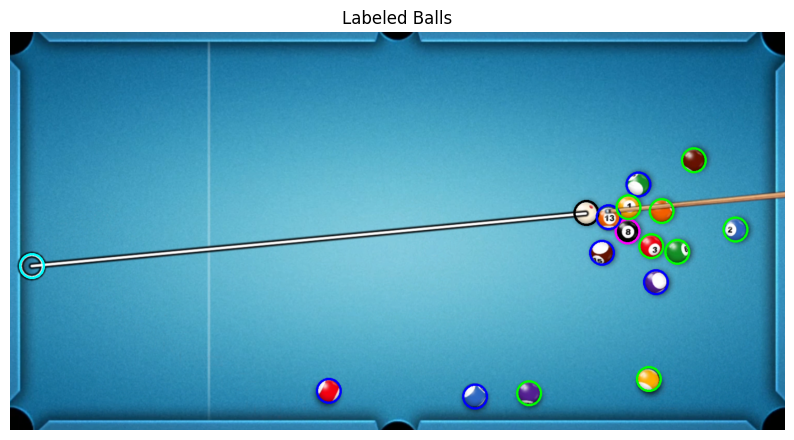

In [5]:
# using model, show solid/stripe labels in a given table
screenshots_dir = Path('./screenshots')
screenshots = sorted(screenshots_dir.glob('screenshot_*.png'))
random.shuffle(screenshots)  # for testing
for ss_num, screenshot in enumerate(screenshots):
    print(screenshot)
    img = cv2.imread(str(screenshot))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # crop image to playable area
    img = img[constants['playable_area']['top_left'][1]:constants['playable_area']['bottom_right'][1],
              constants['playable_area']['top_left'][0]:constants['playable_area']['bottom_right'][0]]
    # crop image by another 5px on each side
    img = img[15:-15, 15:-15]
    # show image
    circles, data = project.generate_data(img, use_blue=False, k_1=2.5, k_2=1.5,
                                 min_dist=20, canny=100, accum=18, min_radius=23, max_radius=27)
    circles = circles[0]
    labels = project.label_balls(img, circles, data)

    COLORS = {
        'cue_ball': (0, 0, 0),       # Bright green
        '8_ball': (255, 0, 255),       # Bright purple/pink
        'solids': (0, 255, 0),         # Bright blue
        'stripes': (0, 0, 255),        # Bright red
        'aim_circle': (0, 255, 255)    # Yellow (optional highlight)
    }
    
    radius = constants['ball_radius']
    labeled_img = img.copy()
    for key, points in labels.items():
        if points is None:
            continue
        if key in ['cue_ball', '8_ball']:
            cv2.circle(labeled_img, tuple(map(int, points)), radius, COLORS[key], 4)
        else:
            for pt in points:
                cv2.circle(labeled_img, tuple(map(int, pt)), radius, COLORS[key], 4)

    plt.figure(figsize=(10, 10))
    plt.imshow(labeled_img)
    plt.axis('off')
    plt.title("Labeled Balls")
    plt.show()

    break
